In [94]:
import math
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.attention import SDPBackend, sdpa_kernel
from gradientlab.logging_utils.log_model_params import pretty_print_model


def _to_2tuple(x: int | Tuple[int, int]) -> Tuple[int, int]:
    return x if isinstance(x, tuple) else (x, x)


class DropPath(nn.Module):
    """Stochastic depth (DropPath) for residual branches."""

    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor


class SwiGLU(nn.Module):
    """
    SwiGLU FFN:
        y = W3( silu(W2 x) * (W1 x) )
    """

    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.0):
        super().__init__()
        self.w12 = nn.Linear(dim, 2 * hidden_dim, bias=True)
        self.w3 = nn.Linear(hidden_dim, dim, bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1, x2 = self.w12(x).chunk(2, dim=-1)
        x = F.silu(x2) * x1
        x = self.dropout(x)
        return self.w3(x)


def window_partition(x: torch.Tensor, window_size: int) -> torch.Tensor:
    """(B,H,W,C) -> (B*nW, ws, ws, C)"""
    B, H, W, C = x.shape
    ws = window_size
    x = x.view(B, H // ws, ws, W // ws, ws, C)
    return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, ws, ws, C)


def window_reverse(
    windows: torch.Tensor, window_size: int, H: int, W: int
) -> torch.Tensor:
    """(B*nW, ws, ws, C) -> (B,H,W,C)"""
    ws = window_size
    B = int(windows.shape[0] / (H * W / (ws * ws)))
    x = windows.view(B, H // ws, W // ws, ws, ws, -1)
    return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)


def compute_shifted_window_mask(
    H: int, W: int, window_size: int, shift_size: int, device: torch.device
) -> torch.Tensor:
    """
    Float mask (nW, N, N) with 0 or -inf to prevent attention across shifted-window boundaries.
    """
    ws = window_size
    img_mask = torch.zeros((1, H, W, 1), device=device)
    h_slices = (slice(0, -ws), slice(-ws, -shift_size), slice(-shift_size, None))
    w_slices = (slice(0, -ws), slice(-ws, -shift_size), slice(-shift_size, None))
    cnt = 0
    for h in h_slices:
        for w in w_slices:
            img_mask[:, h, w, :] = cnt
            cnt += 1

    mask_windows = window_partition(img_mask, ws).view(-1, ws * ws)  # (nW, N)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    return attn_mask.masked_fill(attn_mask != 0, float("-inf")).masked_fill(
        attn_mask == 0, 0.0
    )


class WindowAttentionV2(nn.Module):
    """
    Swin window attention using PyTorch SDPA.
    - Optional cosine attention + per-head logit scale (SwinV2-style)
    - Optional Continuous Position Bias (CPB, SwinV2-style)
    """

    def __init__(
        self,
        dim: int,
        window_size: Tuple[int, int],
        num_heads: int,
        qkv_bias: bool = True,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
        use_cosine_attention: bool = True,
        use_cpb: bool = True,
        force_flash: bool = False,
    ):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert self.head_dim * num_heads == dim, "dim must be divisible by num_heads"

        self.force_flash = bool(force_flash)
        self.use_cosine_attention = bool(use_cosine_attention)
        self.use_cpb = bool(use_cpb)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim, bias=True)
        self.proj_drop = nn.Dropout(proj_drop)
        self.attn_drop = float(attn_drop)

        Wh, Ww = self.window_size
        N = Wh * Ww

        # relative position index (shared by both V1 table and V2 CPB)
        coords_h = torch.arange(Wh)
        coords_w = torch.arange(Ww)
        coords = torch.stack(
            torch.meshgrid(coords_h, coords_w, indexing="ij")
        )  # (2,Wh,Ww)
        coords_flatten = coords.flatten(1)  # (2,N)
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # (2,N,N)
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # (N,N,2)
        relative_coords[:, :, 0] += Wh - 1
        relative_coords[:, :, 1] += Ww - 1
        relative_coords[:, :, 0] *= 2 * Ww - 1
        relative_position_index = relative_coords.sum(-1)  # (N,N)
        self.register_buffer(
            "relative_position_index", relative_position_index, persistent=False
        )

        if self.use_cpb:
            # relative coords table for CPB MLP
            rch = torch.arange(-(Wh - 1), Wh, dtype=torch.float32)
            rcw = torch.arange(-(Ww - 1), Ww, dtype=torch.float32)
            rel_coords_table = (
                torch.stack(torch.meshgrid(rch, rcw, indexing="ij"))
                .permute(1, 2, 0)
                .contiguous()
                .view(-1, 2)
            )
            rel_coords_table[:, 0] /= max(Wh - 1, 1)
            rel_coords_table[:, 1] /= max(Ww - 1, 1)
            rel_coords_table *= 8
            rel_coords_table = (
                torch.sign(rel_coords_table)
                * torch.log2(torch.abs(rel_coords_table) + 1.0)
                / math.log2(8.0)
            )
            self.register_buffer(
                "relative_coords_table", rel_coords_table, persistent=False
            )

            self.cpb_mlp = nn.Sequential(
                nn.Linear(2, 512, bias=True),
                nn.ReLU(inplace=True),
                nn.Linear(512, num_heads, bias=False),
            )
            self.logit_scale = nn.Parameter(
                torch.log(torch.ones(num_heads, 1, 1) * 10.0)
            )
        else:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * Wh - 1) * (2 * Ww - 1), num_heads)
            )
            nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)
            self.logit_scale = None

    def _relative_position_bias(
        self, dtype: torch.dtype, device: torch.device
    ) -> torch.Tensor:
        Wh, Ww = self.window_size
        N = Wh * Ww
        if self.use_cpb:
            bias_table = self.cpb_mlp(
                self.relative_coords_table.to(device=device, dtype=dtype)
            )  # (M, heads)
            bias = bias_table[self.relative_position_index.view(-1)].view(
                N, N, self.num_heads
            )
            return bias.permute(2, 0, 1).contiguous().unsqueeze(0)  # (1, heads, N, N)
        bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(N, N, self.num_heads)
        return bias.permute(2, 0, 1).contiguous().unsqueeze(0)

    def forward(
        self, x: torch.Tensor, attn_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        x: (B_, N, C) where B_ = B*nW, N=ws*ws
        attn_mask: (nW, N, N) with 0 or -inf (shifted window mask), or None.
        """
        B_, N, C = x.shape
        qkv = (
            self.qkv(x)
            .view(B_, N, 3, self.num_heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B_, heads, N, head_dim)

        # SwinV2-style cosine attention
        if self.use_cosine_attention:
            q = F.normalize(q, dim=-1)
            k = F.normalize(k, dim=-1)
            logit_scale = torch.clamp(self.logit_scale, max=math.log(1.0 / 0.01)).exp()
            q = q * logit_scale  # per-head scale baked into q
            scale = 1.0  # avoid extra 1/sqrt(d) scaling inside SDPA
        else:
            scale = None  # default 1/sqrt(head_dim)

        bias = self._relative_position_bias(
            dtype=q.dtype, device=q.device
        )  # (1, heads, N, N)

        if attn_mask is not None:
            nW = attn_mask.shape[0]
            assert B_ % nW == 0
            B = B_ // nW
            attn_mask = attn_mask.to(device=q.device, dtype=q.dtype).unsqueeze(
                1
            )  # (nW,1,N,N)
            attn_mask = attn_mask.repeat(B, 1, 1, 1)  # (B_,1,N,N)
            attn_bias = bias + attn_mask
        else:
            attn_bias = bias

        dropout_p = self.attn_drop if self.training else 0.0

        ctx = (
            sdpa_kernel(SDPBackend.FLASH_ATTENTION)
            if self.force_flash
            else sdpa_kernel(
                [
                    SDPBackend.FLASH_ATTENTION,
                    SDPBackend.EFFICIENT_ATTENTION,
                    SDPBackend.MATH,
                ]
            )
        )
        with ctx:
            out = F.scaled_dot_product_attention(
                q,
                k,
                v,
                attn_mask=attn_bias,
                dropout_p=dropout_p,
                is_causal=False,
                scale=scale,
            )

        out = out.transpose(1, 2).contiguous().view(B_, N, C)
        out = self.proj(out)
        return self.proj_drop(out)


class SwinTransformerBlock(nn.Module):
    """Pre-norm Swin block (W-MSA or SW-MSA + SwiGLU FFN)."""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: int = 8,
        shift_size: int = 0,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        use_cosine_attention: bool = True,
        use_cpb: bool = True,
        force_flash: bool = False,
    ):
        super().__init__()
        self.dim = dim
        self.window_size = int(window_size)
        self.shift_size = int(shift_size)

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttentionV2(
            dim=dim,
            window_size=_to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
            use_cosine_attention=use_cosine_attention,
            use_cpb=use_cpb,
            force_flash=force_flash,
        )
        self.drop_path = DropPath(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = SwiGLU(dim, int(dim * mlp_ratio), dropout=drop)

    def forward(self, x: torch.Tensor, H: int, W: int) -> torch.Tensor:
        B, L, C = x.shape
        assert L == H * W

        shortcut = x
        x = self.norm1(x).view(B, H, W, C)

        ws = self.window_size
        pad_r = (ws - W % ws) % ws
        pad_b = (ws - H % ws) % ws
        if pad_r or pad_b:
            x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b))
        Hp, Wp = x.shape[1], x.shape[2]

        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
            attn_mask = compute_shifted_window_mask(
                Hp, Wp, ws, self.shift_size, device=x.device
            )
        else:
            shifted_x, attn_mask = x, None

        x_windows = window_partition(shifted_x, ws).view(-1, ws * ws, C)
        attn_windows = self.attn(x_windows, attn_mask=attn_mask).view(-1, ws, ws, C)
        shifted_x = window_reverse(attn_windows, ws, Hp, Wp)

        if self.shift_size > 0:
            x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            x = shifted_x

        if pad_r or pad_b:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """Grayscale image -> patch tokens."""

    def __init__(
        self,
        patch_size: int = 4,
        in_chans: int = 1,
        embed_dim: int = 96,
        norm: bool = True,
    ):
        super().__init__()
        self.patch_size = int(patch_size)
        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=self.patch_size, stride=self.patch_size
        )
        self.norm = nn.LayerNorm(embed_dim) if norm else nn.Identity()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, int, int]:
        B, C, H, W = x.shape
        pad_h = (self.patch_size - H % self.patch_size) % self.patch_size
        pad_w = (self.patch_size - W % self.patch_size) % self.patch_size
        if pad_h or pad_w:
            x = F.pad(x, (0, pad_w, 0, pad_h))
        x = self.proj(x)  # (B, D, H', W')
        Ht, Wt = x.shape[2], x.shape[3]
        x = x.flatten(2).transpose(1, 2).contiguous()  # (B, H'*W', D)
        return self.norm(x), Ht, Wt


class PatchMerging(nn.Module):
    """Downsample by 2 (H,W) and double channels."""

    def __init__(self, input_dim: int):
        super().__init__()
        self.norm = nn.LayerNorm(4 * input_dim)
        self.reduction = nn.Linear(4 * input_dim, 2 * input_dim, bias=False)

    def forward(self, x: torch.Tensor, H: int, W: int) -> Tuple[torch.Tensor, int, int]:
        B, L, C = x.shape
        assert L == H * W
        x = x.view(B, H, W, C)

        pad_r = W % 2
        pad_b = H % 2
        if pad_r or pad_b:
            x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b))
        Hp, Wp = x.shape[1], x.shape[2]
        Hn, Wn = Hp // 2, Wp // 2

        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], dim=-1).view(B, Hn * Wn, 4 * C)
        x = self.norm(x)
        x = self.reduction(x)
        return x, Hn, Wn


class SwinStage(nn.Module):
    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: int,
        mlp_ratio: float,
        drop: float,
        attn_drop: float,
        drop_path_rates: List[float],
        downsample: bool,
        use_cosine_attention: bool,
        use_cpb: bool,
        force_flash: bool,
    ):
        super().__init__()
        self.blocks = nn.ModuleList()
        for i in range(depth):
            shift = 0 if (i % 2 == 0) else window_size // 2
            self.blocks.append(
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=shift,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=True,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path_rates[i],
                    use_cosine_attention=use_cosine_attention,
                    use_cpb=use_cpb,
                    force_flash=force_flash,
                )
            )
        self.downsample = PatchMerging(dim) if downsample else None

    def forward(self, x: torch.Tensor, H: int, W: int) -> Tuple[torch.Tensor, int, int]:
        for blk in self.blocks:
            x = blk(x, H, W)
        if self.downsample is not None:
            x, H, W = self.downsample(x, H, W)
        return x, H, W


@dataclass
class SwinEncoderConfig:
    patch_size: int = 4
    embed_dim: int = 96
    depths: Tuple[int, int, int, int] = (2, 2, 6, 2)
    num_heads: Tuple[int, int, int, int] = (3, 6, 12, 24)
    window_size: int = 8
    mlp_ratio: float = 4.0
    drop: float = 0.0
    attn_drop: float = 0.0
    drop_path: float = 0.1
    use_cosine_attention: bool = True
    use_cpb: bool = True
    force_flash: bool = False


class SwinEncoder(nn.Module):
    def __init__(self, cfg: SwinEncoderConfig):
        super().__init__()
        self.cfg = cfg
        self.patch_embed = PatchEmbed(
            patch_size=cfg.patch_size, in_chans=1, embed_dim=cfg.embed_dim, norm=True
        )

        total_depth = sum(cfg.depths)
        dpr = [x.item() for x in torch.linspace(0, cfg.drop_path, total_depth)]
        cur = 0

        self.stages = nn.ModuleList()
        dim = cfg.embed_dim
        for i, depth in enumerate(cfg.depths):
            self.stages.append(
                SwinStage(
                    dim=dim,
                    depth=depth,
                    num_heads=cfg.num_heads[i],
                    window_size=cfg.window_size,
                    mlp_ratio=cfg.mlp_ratio,
                    drop=cfg.drop,
                    attn_drop=cfg.attn_drop,
                    drop_path_rates=dpr[cur : cur + depth],
                    downsample=(i < len(cfg.depths) - 1),
                    use_cosine_attention=cfg.use_cosine_attention,
                    use_cpb=cfg.use_cpb,
                    force_flash=cfg.force_flash,
                )
            )
            cur += depth
            if i < len(cfg.depths) - 1:
                dim *= 2

        self.norm = nn.LayerNorm(dim)
        self.out_dim = dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, H, W = self.patch_embed(x)
        for stage in self.stages:
            x, H, W = stage(x, H, W)
        return self.norm(x)  # (B, S, C)


class FlashMHA(nn.Module):
    """MHA implemented via SDPA (FlashAttention when eligible)."""

    def __init__(
        self, dim: int, num_heads: int, dropout: float = 0.0, force_flash: bool = False
    ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert self.head_dim * num_heads == dim
        self.force_flash = bool(force_flash)

        self.q_proj = nn.Linear(dim, dim, bias=True)
        self.k_proj = nn.Linear(dim, dim, bias=True)
        self.v_proj = nn.Linear(dim, dim, bias=True)
        self.out_proj = nn.Linear(dim, dim, bias=True)
        self.dropout = float(dropout)

    def _sdpa(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        *,
        attn_mask: Optional[torch.Tensor],
        is_causal: bool,
    ) -> torch.Tensor:
        dropout_p = self.dropout if self.training else 0.0
        ctx = (
            sdpa_kernel(SDPBackend.FLASH_ATTENTION)
            if self.force_flash
            else sdpa_kernel(
                [
                    SDPBackend.FLASH_ATTENTION,
                    SDPBackend.EFFICIENT_ATTENTION,
                    SDPBackend.MATH,
                ]
            )
        )
        with ctx:
            return F.scaled_dot_product_attention(
                q, k, v, attn_mask=attn_mask, dropout_p=dropout_p, is_causal=is_causal
            )

    def forward(
        self,
        x_q: torch.Tensor,
        x_kv: Optional[torch.Tensor] = None,
        *,
        attn_mask: Optional[torch.Tensor] = None,
        is_causal: bool = False,
        kv_cache: Optional[Dict[str, torch.Tensor]] = None,
        cache_prefix: str = "self",
    ) -> Tuple[torch.Tensor, Optional[Dict[str, torch.Tensor]]]:
        if x_kv is None:
            x_kv = x_q

        B, L, D = x_q.shape
        S = x_kv.shape[1]

        q = (
            self.q_proj(x_q).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        )  # (B,h,L,hd)
        k = self.k_proj(x_kv).view(B, S, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x_kv).view(B, S, self.num_heads, self.head_dim).transpose(1, 2)

        if kv_cache is not None:
            k_key, v_key = f"{cache_prefix}_k", f"{cache_prefix}_v"
            if k_key in kv_cache and v_key in kv_cache:
                k = torch.cat([kv_cache[k_key], k], dim=2)
                v = torch.cat([kv_cache[v_key], v], dim=2)
            kv_cache[k_key] = k
            kv_cache[v_key] = v
            # With incremental decoding and no future keys, causal masking is unnecessary.
            is_causal = False

        out = self._sdpa(q, k, v, attn_mask=attn_mask, is_causal=is_causal)
        out = out.transpose(1, 2).contiguous().view(B, L, D)
        return self.out_proj(out), kv_cache


class DecoderBlock(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        dropout: float = 0.0,
        drop_path: float = 0.0,
        force_flash: bool = False,
    ):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.self_attn = FlashMHA(
            dim, num_heads, dropout=dropout, force_flash=force_flash
        )
        self.dp1 = DropPath(drop_path)

        self.norm2 = nn.LayerNorm(dim)
        self.cross_attn = FlashMHA(
            dim, num_heads, dropout=dropout, force_flash=force_flash
        )
        self.dp2 = DropPath(drop_path)

        self.norm3 = nn.LayerNorm(dim)
        self.mlp = SwiGLU(dim, int(dim * mlp_ratio), dropout=dropout)
        self.dp3 = DropPath(drop_path)

    def forward(
        self,
        x: torch.Tensor,
        memory: torch.Tensor,
        *,
        is_causal: bool,
        self_attn_mask: Optional[torch.Tensor] = None,
        kv_cache: Optional[Dict[str, torch.Tensor]],
        layer_idx: int,
    ) -> Tuple[torch.Tensor, Optional[Dict[str, torch.Tensor]]]:
        h = self.norm1(x)
        h, kv_cache = self.self_attn(
            h,
            None,
            attn_mask=self_attn_mask,
            is_causal=is_causal,
            kv_cache=kv_cache,
            cache_prefix=f"l{layer_idx}_self",
        )
        x = x + self.dp1(h)

        h = self.norm2(x)
        h, _ = self.cross_attn(h, memory, is_causal=False, kv_cache=None)
        x = x + self.dp2(h)

        x = x + self.dp3(self.mlp(self.norm3(x)))
        return x, kv_cache


@dataclass
class DecoderConfig:
    vocab_size: int = 32000
    d_model: int = 512
    n_layers: int = 6
    n_heads: int = 8
    mlp_ratio: float = 4.0
    dropout: float = 0.0
    drop_path: float = 0.1
    max_seq_len: int = 256
    force_flash: bool = False
    tie_embeddings: bool = True


class TransformerDecoder(nn.Module):
    def __init__(self, cfg: DecoderConfig):
        super().__init__()
        self.cfg = cfg
        self.tok_emb = nn.Embedding(cfg.vocab_size, cfg.d_model)
        self.pos_emb = nn.Embedding(cfg.max_seq_len, cfg.d_model)
        self.drop = nn.Dropout(cfg.dropout)

        dpr = [x.item() for x in torch.linspace(0, cfg.drop_path, cfg.n_layers)]
        self.blocks = nn.ModuleList(
            [
                DecoderBlock(
                    dim=cfg.d_model,
                    num_heads=cfg.n_heads,
                    mlp_ratio=cfg.mlp_ratio,
                    dropout=cfg.dropout,
                    drop_path=dpr[i],
                    force_flash=cfg.force_flash,
                )
                for i in range(cfg.n_layers)
            ]
        )
        self.norm = nn.LayerNorm(cfg.d_model)
        self.lm_head = nn.Linear(cfg.d_model, cfg.vocab_size, bias=False)
        if cfg.tie_embeddings:
            self.lm_head.weight = self.tok_emb.weight

    @staticmethod
    def _build_causal_padding_mask(attention_mask: torch.Tensor) -> torch.Tensor:
        """
        Returns (B, 1, T, T) boolean mask for SDPA where True means "allowed to attend".
        Fuses:
          - causal (lower-triangular)
          - key padding (cannot attend to pad keys)

        Also relaxes causal constraint for padded query positions to avoid fully-masked rows
        with left-padding (outputs at pad positions should be ignored anyway).
        """
        if attention_mask.ndim != 2:
            raise ValueError(f"attention_mask must be (B, T), got {tuple(attention_mask.shape)}")

        key_valid = attention_mask.to(dtype=torch.bool)  # (B, T)
        B, T = key_valid.shape

        # Avoid degenerate all-pad sequences causing fully-masked rows.
        all_pad = key_valid.sum(dim=1) == 0
        if all_pad.any():
            key_valid = key_valid.clone()
            key_valid[all_pad, 0] = True

        # Key mask: which keys are attendable
        key_mask = key_valid[:, None, None, :]     # (B, 1, 1, T)
        key_mask = key_mask.expand(B, 1, T, T)     # (B, 1, T, T)

        # Causal mask
        causal = torch.ones((T, T), device=key_valid.device, dtype=torch.bool).tril()
        causal = causal[None, None, :, :]          # (1, 1, T, T)

        attn = causal & key_mask                   # (B, 1, T, T)

        # If query is padding, relax causal constraint to avoid fully-masked rows in left-pad.
        pad_q = ~attention_mask.to(dtype=torch.bool)   # (B, T)
        attn = torch.where(pad_q[:, None, :, None], key_mask, attn)
        return attn

    def forward(
        self,
        input_ids: torch.Tensor,
        memory: torch.Tensor,
        *,
        attention_mask: Optional[torch.Tensor] = None,
        kv_cache: Optional[Dict[str, torch.Tensor]] = None,
        use_cache: bool = False,
        pos_offset: int = 0,
    ) -> Tuple[torch.Tensor, Optional[Dict[str, torch.Tensor]]]:
        B, T = input_ids.shape
        assert pos_offset + T <= self.cfg.max_seq_len, "position exceeds max_seq_len"

        pos = (
            (pos_offset + torch.arange(T, device=input_ids.device))
            .unsqueeze(0)
            .expand(B, T)
        )
        x = self.tok_emb(input_ids) + self.pos_emb(pos)
        x = self.drop(x)

        # If attention_mask is provided, fuse causal+padding into a boolean mask and set is_causal=False.
        self_attn_mask: Optional[torch.Tensor] = None
        causal_hint = True
        if attention_mask is not None:
            self_attn_mask = self._build_causal_padding_mask(
                attention_mask.to(device=input_ids.device)
            )
            causal_hint = False

        cache = (
            kv_cache
            if (use_cache and kv_cache is not None)
            else ({} if use_cache else None)
        )

        for i, blk in enumerate(self.blocks):
            x, cache = blk(
                x,
                memory,
                is_causal=causal_hint,
                self_attn_mask=self_attn_mask,
                kv_cache=cache,
                layer_idx=i,
            )

        x = self.norm(x)
        logits = self.lm_head(x)
        return logits, cache



@dataclass
class ModelConfig:
    pad_token_id: int
    encoder: SwinEncoderConfig = field(default_factory=SwinEncoderConfig)
    decoder: DecoderConfig = field(default_factory=DecoderConfig)
    enc_to_dec_proj: bool = True
    vocab_size: int = 512


class SwinImageToText(nn.Module):
    """
    Grayscale image (B,1,N,N) -> token logits (B,T,vocab) via Swin encoder + Transformer decoder.
    """

    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.cfg = cfg
        self.encoder = SwinEncoder(cfg.encoder)
        self.decoder = TransformerDecoder(cfg.decoder)
        self.enc_proj = (
            nn.Linear(self.encoder.out_dim, cfg.decoder.d_model, bias=False)
            if (cfg.enc_to_dec_proj and self.encoder.out_dim != cfg.decoder.d_model)
            else nn.Identity()
        )
        self.apply(self._init_weights)

    def encode(self, pixel_values: torch.Tensor) -> torch.Tensor:
        return self.enc_proj(self.encoder(pixel_values))

    def forward(
        self,
        pixel_values: torch.Tensor,
        input_ids: torch.Tensor,
        labels: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        memory = self.encode(pixel_values)
        logits, _ = self.decoder(
            input_ids,
            memory,
            attention_mask=attention_mask,
            use_cache=False,
            pos_offset=0,
        )
        loss = None
        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = F.cross_entropy(
                shift_logits.view(-1, self.cfg.vocab_size),
                shift_labels.view(-1),
                ignore_index=self.cfg.pad_token_id,
            )
            return {"loss": loss, "logits": logits, "img_embeds": memory}
        
        return {"loss": None, "logits": logits, "img_embeds": memory}
    
    @torch.no_grad()
    def generate(
        self,
        images: torch.Tensor,
        *,
        bos_token_id: int,
        eos_token_id: int,
        max_new_tokens: int = 128,
    ) -> torch.Tensor:
        """Greedy decoding with per-layer KV cache."""
        self.eval()
        memory = self.encode(images)
        B = images.shape[0]
        device = images.device

        tokens = torch.full((B, 1), bos_token_id, dtype=torch.long, device=device)
        cache: Dict[str, torch.Tensor] = {}

        for _ in range(max_new_tokens):
            logits, cache = self.decoder(
                tokens[:, -1:],
                memory,
                kv_cache=cache,
                use_cache=True,
                pos_offset=tokens.shape[1] - 1,
            )
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
            tokens = torch.cat([tokens, next_token], dim=1)
            if (next_token == eos_token_id).all():
                break

        return tokens
    
    def _init_weights(self, module):
        std = 0.05
        if isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=1 / math.sqrt(self.cfg.encoder.embed_dim))
            module.weight.data[self.cfg.pad_token_id].zero_()
        elif isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

In [95]:
from gradientlab.tokenizers.byte_tokenizer import byte_tokenizer


tokenizer = byte_tokenizer()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"

cfg = ModelConfig(
    vocab_size=tokenizer.total_vocab_size,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
    encoder=SwinEncoderConfig(
        patch_size=4,
        embed_dim=48,
        depths=(2, 2, 2, 2),
        num_heads=(2, 2, 4, 8),
        drop=0.05,
        attn_drop=0.05,
        drop_path=0.05,
        window_size=8,
        force_flash=False,
    ),
    decoder=DecoderConfig(
        vocab_size=tokenizer.total_vocab_size,
        d_model=128,
        n_layers=4,
        n_heads=8,
        max_seq_len=4096,
        force_flash=False,
        dropout=0.05,
        drop_path=0.05,
    ),
)

In [96]:
from datasets import load_from_disk

ds = load_from_disk("/Volumes/Lexar/datasets/textimgzip")["train"]

model = SwinImageToText(cfg).to(device)
# model = torch.compile(model)
pretty_print_model(model)

Module Name                | Number of Parameters
---------------------------+---------------------
encoder                    |            6,711,504
decoder                    |            1,912,576
enc_proj                   |               49,152
---------------------------+---------------------
Total trainable params     |            8,673,232
Total non-trainable params |                    0


8673232

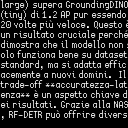

In [56]:
ds[0]["pixel_values"]

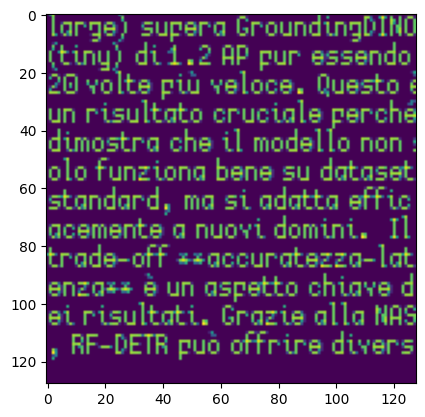

In [74]:
from torchvision.transforms import v2
import matplotlib.pyplot as plt


T = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.1533,), (0.3034, )),
])

plt.imshow(T(ds[0]["pixel_values"]).squeeze(0))

In [13]:
def map_stats(batch):
    tensors = [T(img) for img in batch["pixel_values"]]
    batch["mean"] = [torch.mean(t).item() for t in tensors]
    batch["std"] = [torch.std(t).item() for t in tensors]
    return batch

def get_global_stats(per_image_stats):
    all_means = [s['mean'] for s in per_image_stats]
    all_stds = [s['std'] for s in per_image_stats]
    
    global_mean = sum(all_means) / len(all_means)
    global_std = sum(all_stds) / len(all_stds)
    
    return global_mean, global_std

ds_with_stats = ds.map(map_stats, batched=True, batch_size=100)

get_global_stats(ds_with_stats)

Map: 100%|██████████| 3535/3535 [00:04<00:00, 766.52 examples/s] 


(0.15332323513263796, 0.3034124700592296)

In [75]:
def collate_fn(batch: list):
    images = torch.stack([T(el["pixel_values"]) for el in batch])
    encoded = tokenizer(["<|im_start|>" + el["text"] + "<|im_end|>" for el in batch], add_special_tokens=False, padding="longest", padding_side="right", return_tensors="pt", pad_to_multiple_of=8)
    return {"pixel_values": images, **encoded}


batch = collate_fn(ds.select(list(range(8))))
batch = {k: v.to(device) for k, v in batch.items()}

batch["pixel_values"].shape

torch.Size([8, 1, 128, 128])

In [76]:
batch["input_ids"], batch["attention_mask"]

(tensor([[259, 111, 100,  ..., 117, 118, 260],
         [259,  76,  35,  ..., 260,   0,   0],
         [259, 108, 118,  ..., 115, 260,   0],
         ...,
         [259, 102, 104,  ...,   0,   0,   0],
         [259, 119, 114,  ..., 117, 108, 260],
         [259, 104, 119,  ..., 260,   0,   0]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 0, 0],
         [1, 1, 1,  ..., 1, 1, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 0, 0]]))

In [77]:
batch["input_ids"].shape

torch.Size([8, 344])

In [97]:
out = model(**batch, labels=batch["input_ids"].clone())
out

{'loss': tensor(6.3879, grad_fn=<NllLossBackward0>),
 'logits': tensor([[[-0.0846, -0.5315, -1.0457,  ...,  0.3994, -0.6960,  0.1793],
          [-0.5994, -0.4827,  0.0534,  ...,  0.5359, -0.0083,  0.2551],
          [-0.8834, -0.6156, -0.3892,  ..., -0.2348,  0.2610,  0.5491],
          ...,
          [-0.6561, -0.2512, -1.0213,  ..., -0.5747,  0.0379,  0.7106],
          [-0.3841, -0.0619, -0.6512,  ..., -0.2994, -0.1290, -0.6898],
          [-0.2805,  0.1623, -1.0910,  ..., -0.1484, -0.1793,  0.0029]],
 
         [[ 0.2847, -0.1090, -0.2594,  ..., -0.4718, -0.5911,  0.8736],
          [-0.3874, -0.0822,  0.1388,  ..., -0.8580,  0.0725,  0.3294],
          [-0.2776, -0.2678,  0.0859,  ..., -0.7330, -0.0277,  0.4429],
          ...,
          [ 0.5836,  0.3518,  0.8767,  ..., -1.5617,  0.5806,  0.2966],
          [ 0.8166,  0.3718, -0.0182,  ..., -0.7788,  0.1138,  0.2177],
          [ 0.7491, -0.2480,  0.4324,  ..., -0.5197,  1.0242,  0.3184]],
 
         [[-0.4533, -0.5200, -0.5908,

In [56]:
images = torch.randn(2, 1, 128, 128, device=device)
decoder_in = torch.randint(0, cfg.decoder.vocab_size, (2, 24), device=device)
logits, img_embeds = model(images, decoder_in)
print("logits:", logits.shape)
print("img_embeds:", img_embeds.shape)

logits: torch.Size([2, 24, 256])
img_embeds: torch.Size([2, 16, 128])


In [58]:
out = model.generate(images, bos_token_id=1, eos_token_id=2, max_new_tokens=16)
print("generated:", out.shape)

generated: torch.Size([2, 17])
